In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

2022-07-30 12:11:56.523299: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

In [3]:
n = 8
n_node = 8

In [4]:
K = tc.set_backend('jax')

In [5]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_test = x_test / 255.0
x_test = x_test - mean


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

In [6]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return -jnp.mean(y * jnp.log(probs) + (1 - y) * jnp.log(1 - probs))
loss = K.jit(loss, static_argnums=[3])

In [7]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [8]:
k = 6

In [9]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/99: loss=0.7614, acc=0.0000
epoch 0, 20/99: loss=0.2982, acc=0.4766
epoch 0, 40/99: loss=0.1592, acc=0.8516
epoch 0, 60/99: loss=0.0720, acc=0.9766
epoch 0, 80/99: loss=0.0477, acc=0.9844
epoch 1, 0/99: loss=0.0443, acc=0.9766
epoch 1, 20/99: loss=0.0357, acc=0.9922
epoch 1, 40/99: loss=0.0277, acc=0.9922
epoch 1, 60/99: loss=0.0245, acc=1.0000
epoch 1, 80/99: loss=0.0186, acc=1.0000
epoch 2, 0/99: loss=0.0262, acc=0.9844
epoch 2, 20/99: loss=0.0226, acc=0.9922
epoch 2, 40/99: loss=0.0227, acc=0.9844
epoch 2, 60/99: loss=0.0193, acc=0.9844
epoch 2, 80/99: loss=0.0166, acc=1.0000
epoch 3, 0/99: loss=0.0213, acc=0.9844
epoch 3, 20/99: loss=0.0160, acc=1.0000
epoch 3, 40/99: loss=0.0175, acc=0.9922
epoch 3, 60/99: loss=0.0105, acc=1.0000
epoch 3, 80/99: loss=0.0109, acc=1.0000
epoch 4, 0/99: loss=0.0183, acc=0.9844
epoch 4, 20/99: loss=0.0161, acc=0.9922
epoch 4, 40/99: loss=0.0121, acc=0.9922
epoch 4, 60/99: loss=0.0096, acc=1.0000
epoch 4, 80/99: loss=0.0087, acc=1.0000


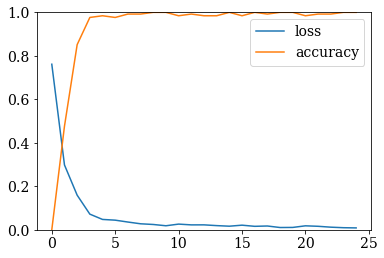

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/93: loss=0.3205, acc=0.4766
epoch 0, 20/93: loss=0.1373, acc=0.8516
epoch 0, 40/93: loss=0.0928, acc=0.9219
epoch 0, 60/93: loss=0.0696, acc=0.9688
epoch 0, 80/93: loss=0.0636, acc=0.9375
epoch 1, 0/93: loss=0.0590, acc=0.9531
epoch 1, 20/93: loss=0.0462, acc=0.9453
epoch 1, 40/93: loss=0.0459, acc=0.9688
epoch 1, 60/93: loss=0.0456, acc=0.9844
epoch 1, 80/93: loss=0.0379, acc=0.9766
epoch 2, 0/93: loss=0.0354, acc=0.9844
epoch 2, 20/93: loss=0.0451, acc=0.9531
epoch 2, 40/93: loss=0.0480, acc=0.9688
epoch 2, 60/93: loss=0.0398, acc=0.9688
epoch 2, 80/93: loss=0.0388, acc=0.9844
epoch 3, 0/93: loss=0.0403, acc=0.9609
epoch 3, 20/93: loss=0.0401, acc=0.9766
epoch 3, 40/93: loss=0.0368, acc=0.9688
epoch 3, 60/93: loss=0.0360, acc=0.9688
epoch 3, 80/93: loss=0.0324, acc=0.9844
epoch 4, 0/93: loss=0.0349, acc=0.9609
epoch 4, 20/93: loss=0.0409, acc=0.9688
epoch 4, 40/93: loss=0.0318, acc=0.9844
epoch 4, 60/93: loss=0.0299, acc=0.9766
epoch 4, 80/93: loss=0.0363, acc=0.9844


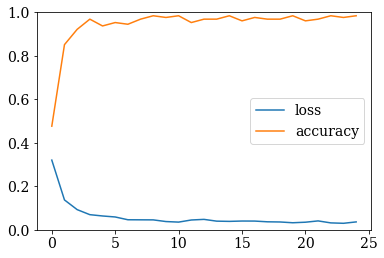

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/95: loss=0.3736, acc=0.2500
epoch 0, 20/95: loss=0.1974, acc=0.7266
epoch 0, 40/95: loss=0.0895, acc=0.9375
epoch 0, 60/95: loss=0.0640, acc=0.9844
epoch 0, 80/95: loss=0.0569, acc=0.9688
epoch 1, 0/95: loss=0.0568, acc=0.9688
epoch 1, 20/95: loss=0.0497, acc=0.9609
epoch 1, 40/95: loss=0.0428, acc=0.9766
epoch 1, 60/95: loss=0.0321, acc=0.9844
epoch 1, 80/95: loss=0.0287, acc=1.0000
epoch 2, 0/95: loss=0.0419, acc=0.9688
epoch 2, 20/95: loss=0.0429, acc=0.9531
epoch 2, 40/95: loss=0.0301, acc=0.9766
epoch 2, 60/95: loss=0.0276, acc=0.9844
epoch 2, 80/95: loss=0.0252, acc=1.0000
epoch 3, 0/95: loss=0.0323, acc=0.9922
epoch 3, 20/95: loss=0.0337, acc=0.9766
epoch 3, 40/95: loss=0.0278, acc=0.9766
epoch 3, 60/95: loss=0.0235, acc=1.0000
epoch 3, 80/95: loss=0.0183, acc=1.0000
epoch 4, 0/95: loss=0.0261, acc=0.9922
epoch 4, 20/95: loss=0.0266, acc=0.9766
epoch 4, 40/95: loss=0.0254, acc=0.9844
epoch 4, 60/95: loss=0.0192, acc=0.9844
epoch 4, 80/95: loss=0.0178, acc=1.0000


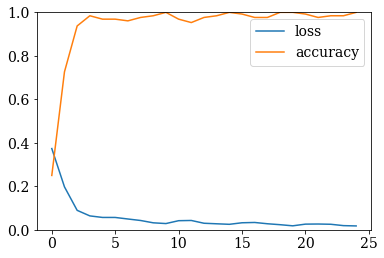

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/92: loss=0.4402, acc=0.2109
epoch 0, 20/92: loss=0.1570, acc=0.8281
epoch 0, 40/92: loss=0.0924, acc=0.9453
epoch 0, 60/92: loss=0.0732, acc=0.9609
epoch 0, 80/92: loss=0.0590, acc=0.9609
epoch 1, 0/92: loss=0.0474, acc=0.9844
epoch 1, 20/92: loss=0.0390, acc=0.9844
epoch 1, 40/92: loss=0.0328, acc=0.9922
epoch 1, 60/92: loss=0.0358, acc=0.9844
epoch 1, 80/92: loss=0.0258, acc=0.9922
epoch 2, 0/92: loss=0.0262, acc=0.9922
epoch 2, 20/92: loss=0.0252, acc=1.0000
epoch 2, 40/92: loss=0.0212, acc=0.9922
epoch 2, 60/92: loss=0.0310, acc=0.9844
epoch 2, 80/92: loss=0.0210, acc=1.0000
epoch 3, 0/92: loss=0.0194, acc=1.0000
epoch 3, 20/92: loss=0.0201, acc=0.9922
epoch 3, 40/92: loss=0.0206, acc=0.9844
epoch 3, 60/92: loss=0.0220, acc=0.9766
epoch 3, 80/92: loss=0.0193, acc=0.9922
epoch 4, 0/92: loss=0.0197, acc=0.9922
epoch 4, 20/92: loss=0.0186, acc=1.0000
epoch 4, 40/92: loss=0.0144, acc=0.9922
epoch 4, 60/92: loss=0.0231, acc=0.9766
epoch 4, 80/92: loss=0.0182, acc=0.9922


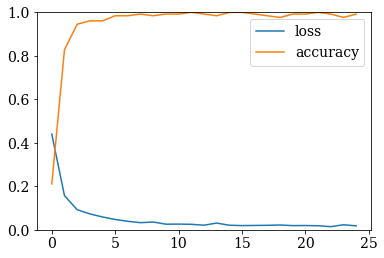

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/89: loss=0.3872, acc=0.2188
epoch 0, 20/89: loss=0.1781, acc=0.8047
epoch 0, 40/89: loss=0.1167, acc=0.8984
epoch 0, 60/89: loss=0.1105, acc=0.9141
epoch 0, 80/89: loss=0.0790, acc=0.9297
epoch 1, 0/89: loss=0.0789, acc=0.9297
epoch 1, 20/89: loss=0.0657, acc=0.9609
epoch 1, 40/89: loss=0.0580, acc=0.9922
epoch 1, 60/89: loss=0.0663, acc=0.9531
epoch 1, 80/89: loss=0.0587, acc=0.9688
epoch 2, 0/89: loss=0.0645, acc=0.9609
epoch 2, 20/89: loss=0.0521, acc=0.9922
epoch 2, 40/89: loss=0.0440, acc=0.9844
epoch 2, 60/89: loss=0.0589, acc=0.9688
epoch 2, 80/89: loss=0.0484, acc=0.9688
epoch 3, 0/89: loss=0.0540, acc=0.9688
epoch 3, 20/89: loss=0.0485, acc=0.9844
epoch 3, 40/89: loss=0.0428, acc=0.9844
epoch 3, 60/89: loss=0.0522, acc=0.9609
epoch 3, 80/89: loss=0.0393, acc=0.9688
epoch 4, 0/89: loss=0.0463, acc=0.9766
epoch 4, 20/89: loss=0.0436, acc=1.0000
epoch 4, 40/89: loss=0.0430, acc=0.9766
epoch 4, 60/89: loss=0.0472, acc=0.9766
epoch 4, 80/89: loss=0.0409, acc=0.9844


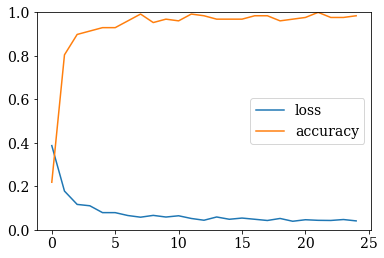

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/93: loss=0.4005, acc=0.1484
epoch 0, 20/93: loss=0.1703, acc=0.7500
epoch 0, 40/93: loss=0.1373, acc=0.8438
epoch 0, 60/93: loss=0.1006, acc=0.8984
epoch 0, 80/93: loss=0.0718, acc=0.9766
epoch 1, 0/93: loss=0.0661, acc=0.9766
epoch 1, 20/93: loss=0.0553, acc=0.9766
epoch 1, 40/93: loss=0.0685, acc=0.9297
epoch 1, 60/93: loss=0.0606, acc=0.9453
epoch 1, 80/93: loss=0.0476, acc=0.9844
epoch 2, 0/93: loss=0.0429, acc=0.9688
epoch 2, 20/93: loss=0.0513, acc=0.9453
epoch 2, 40/93: loss=0.0448, acc=0.9609
epoch 2, 60/93: loss=0.0519, acc=0.9453
epoch 2, 80/93: loss=0.0425, acc=0.9688
epoch 3, 0/93: loss=0.0384, acc=0.9844
epoch 3, 20/93: loss=0.0399, acc=0.9688
epoch 3, 40/93: loss=0.0393, acc=0.9531
epoch 3, 60/93: loss=0.0493, acc=0.9453
epoch 3, 80/93: loss=0.0297, acc=0.9922
epoch 4, 0/93: loss=0.0352, acc=0.9766
epoch 4, 20/93: loss=0.0308, acc=0.9688
epoch 4, 40/93: loss=0.0359, acc=0.9766
epoch 4, 60/93: loss=0.0324, acc=0.9609
epoch 4, 80/93: loss=0.0289, acc=0.9844


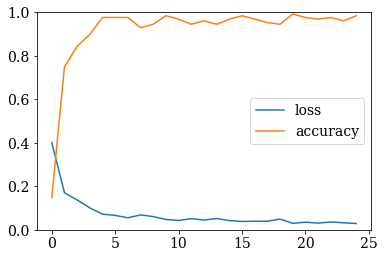

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/96: loss=0.4643, acc=0.0312
epoch 0, 20/96: loss=0.1971, acc=0.8750
epoch 0, 40/96: loss=0.1026, acc=0.9688
epoch 0, 60/96: loss=0.0696, acc=0.9844
epoch 0, 80/96: loss=0.0565, acc=0.9922
epoch 1, 0/96: loss=0.0520, acc=0.9844
epoch 1, 20/96: loss=0.0462, acc=0.9922
epoch 1, 40/96: loss=0.0380, acc=0.9922
epoch 1, 60/96: loss=0.0473, acc=0.9844
epoch 1, 80/96: loss=0.0454, acc=0.9688
epoch 2, 0/96: loss=0.0395, acc=1.0000
epoch 2, 20/96: loss=0.0389, acc=1.0000
epoch 2, 40/96: loss=0.0360, acc=0.9844
epoch 2, 60/96: loss=0.0349, acc=1.0000
epoch 2, 80/96: loss=0.0349, acc=0.9922
epoch 3, 0/96: loss=0.0352, acc=1.0000
epoch 3, 20/96: loss=0.0327, acc=1.0000
epoch 3, 40/96: loss=0.0329, acc=0.9922
epoch 3, 60/96: loss=0.0341, acc=1.0000
epoch 3, 80/96: loss=0.0331, acc=0.9922
epoch 4, 0/96: loss=0.0362, acc=1.0000
epoch 4, 20/96: loss=0.0280, acc=1.0000
epoch 4, 40/96: loss=0.0292, acc=1.0000
epoch 4, 60/96: loss=0.0335, acc=1.0000
epoch 4, 80/96: loss=0.0356, acc=0.9922


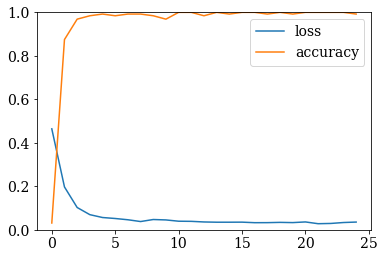

In [23]:
params_list = []
gmm_list = []
all_train_loss = []
all_train_acc = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    data = tf.data.Dataset.from_tensor_slices((x_train_small, y_train_node)).shuffle(100).batch(128)

    # GMM
    gmm = GaussianMixture(n_components=5, max_iter=100)
    gmm.fit(x_train_small)
    gmm_list.append(gmm)

    params = K.randn((k * 2, n), dtype=jnp.float32)
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)

    loss_list = []
    acc_list = []
    for e in tqdm(range(5), leave=False):
        for i, (x, y) in enumerate(data):
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params, x, y, k)
            updates, opt_state = opt.update(grad_val, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss_mean = jnp.mean(loss_val)
            if i % 20 == 0:
                acc = jnp.mean(compute_accuracy(params, x, y, k))
                acc_list.append(acc)
                loss_list.append(loss_mean)
                print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')
    all_train_loss.append(loss_list)
    all_train_acc.append(acc_list)
    

    plt.plot(loss_list)
    plt.plot(acc_list)
    plt.legend(['loss', 'accuracy'])
    plt.ylim(0, 1)
    plt.show()

    params_list.append(params)


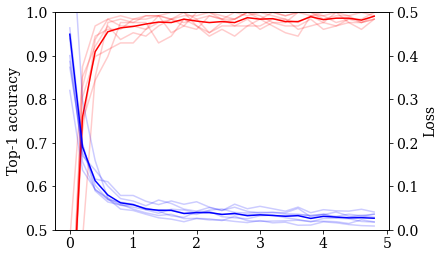

In [52]:
for acc_curve in all_train_acc:
    plt.plot(acc_curve, c='red', alpha=0.2)
avg_acc_curve = jnp.mean(jnp.array(all_train_acc), axis=0)
plt.plot(avg_acc_curve, c='red', label='accuracy')
plt.ylim(0.5, 1)
plt.ylabel('Top-1 accuracy')
plt.twinx()

for loss_curve in all_train_loss:
    plt.plot(loss_curve, c='blue', alpha=0.2)
avg_loss_curve = jnp.mean(jnp.array(all_train_loss), axis=0)
plt.plot(avg_loss_curve, c='blue', label='loss')
plt.ylim(0, 0.5)
plt.ylabel('Loss')

plt.xlabel('Epochs')
plt.xticks([0, 5, 10, 15, 20, 25], [0, 1, 2, 3, 4, 5])
plt.savefig('client_loss_acc.pdf')
plt.show()

In [27]:
def pred(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return probs
# pred = K.jit(pred, static_argnums=[3])

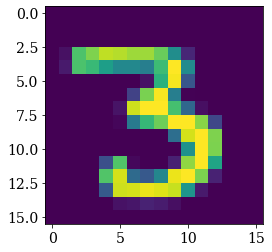

[0. 0. 0. 1. 0. 0. 0. 0.]


DeviceArray([7.6866616e-03, 4.5519944e-05, 1.3268876e-04, 9.9102944e-01,
             8.0940238e-04, 2.1069759e-04, 3.2058422e-05, 5.3604050e-05],            dtype=float32)

In [28]:
i = 3
x_train_node, y_train_node = filter_pair(x_train, y_train, 0, 2 + 1)
x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
plt.imshow(x_train_small[i].reshape(16, 16))
plt.show()
print(y_train_node[i])
pred(params_list[2], x_train_small[i], y_train_node[i], k)

In [29]:
density_est_list = []
p_node = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    # x_train_node = x_train_node[:1000]
    # y_train_node = y_train_node[:1000]
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    dm = jnp.einsum('nij, njk -> nik', jnp.conjugate(x_train_small.reshape(-1, 2**n, 1)), x_train_small.reshape(-1, 1, 2**n))
    density_est_list.append(jnp.mean(dm, axis=0))
    p_node.append(len(x_train_small))
density_est_list = jnp.stack(density_est_list, axis=0)
p_node = jnp.stack(p_node, axis=0) / jnp.sum(jnp.array(p_node))

  0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
from itertools import combinations
trace_dist_list = []
for dm1, dm2 in combinations(density_est_list, 2):
    diff = dm1 - dm2
    eigenvals = jnp.linalg.eigh(diff)[0]
    trace_dist = jnp.sum(jnp.abs(eigenvals)) / 2
    trace_dist_list.append(trace_dist)
trace_dist_list = jnp.stack(trace_dist_list, axis=0)
print(trace_dist_list)
print(jnp.mean(trace_dist_list), jnp.std(trace_dist_list))
print((1 + jnp.mean(trace_dist_list)) / 2)

[0.38609353 0.39015436 0.41028053 0.4130728  0.4128412  0.40908492
 0.27013138 0.3073421  0.30810428 0.2896704  0.3419245  0.3336453
 0.22087297 0.33818638 0.34396785 0.29891497 0.3051919  0.28791517
 0.29639605 0.33918315 0.3883878 ]
0.3376839 0.05277701
0.66884196


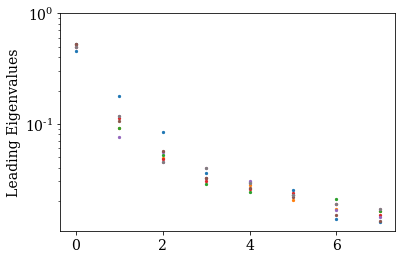

In [31]:
for i in range(n_node):
    plt.scatter(jnp.arange(8), jnp.linalg.eigh(density_est_list[i])[0][::-1][:8], s=5)
plt.yscale('log')
plt.ylabel('Leading Eigenvalues')
plt.ylim(top=1)
plt.show()

In [32]:
p_node

DeviceArray([0.15124556, 0.14188302, 0.14394899, 0.14049774, 0.13547017,
             0.14140534, 0.14554922], dtype=float32)

In [33]:
def pred_comb_with_gmm(params, x, gmm_scores, k, d_mode='GMM'):
    dm_list = []
    for node in range(n_node-1):
        c = tc.Circuit(n, inputs=x)
        for j in range(k):
            for i in range(n - 1):
                c.cnot(i, i + 1)
            for i in range(n):
                c.rx(i, theta=params[node][2 * j, i])
                c.ry(i, theta=params[node][2 * j + 1, i])
        density_matrix = jnp.conjugate(c.wavefunction('ket')) @ c.wavefunction('bra')
        dm_list.append(density_matrix)

    if d_mode == 'DM':
        projector = jnp.conjugate(x.reshape(-1, 1)) @ x.reshape(1, -1)
        weight = jnp.einsum('nij, ji -> n', density_est_list, projector).reshape(-1, 1, 1) * p_node.reshape(-1, 1, 1)
        weight = (weight)**10
        weight = weight / jnp.sum(weight)
    elif d_mode == 'GMM':
        weight = jnp.exp(gmm_scores - jnp.max(gmm_scores)).reshape(-1) * p_node
        weight = weight / jnp.sum(weight)
        weight = weight.reshape(-1, 1, 1)
    else:
        print('d_mode must be DM or GMM')
        return None

    dm = jnp.sum(jnp.stack(dm_list, axis=0) * weight, axis=0)
    # print(jnp.trace(dm))
    c = tc.DMCircuit(n, dminputs=dm)
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    pred_prob = jax.nn.softmax(logits)

    # pred_prob = []
    # for node in range(n_node):
    #     c = tc.DMCircuit(n, dminputs=dm_list[node])
    #     pred_prob.append(1-(jnp.real(c.expectation([tc.gates.z(), [node,]])) + 1) / 2)

    # # print(pred_prob)
    # # print(weight)
    # pred_prob = jnp.stack(pred_prob, axis=0) * weight.reshape(-1)
    # pred_prob = jnp.hstack([1-jnp.sum(pred_prob), pred_prob])

    return pred_prob
pred_comb_with_gmm = K.vmap(pred_comb_with_gmm, vectorized_argnums=[1, 2])

def pred_comb(params, x, k, d_mode='GMM'):
    gmm_scores_list = []
    for node in range(n_node-1):
        gmm_scores = gmm_list[node].score_samples(x)
        gmm_scores_list.append(gmm_scores)
    gmm_scores_list = jnp.stack(gmm_scores_list, axis=-1)
    
    pred_prob = pred_comb_with_gmm(params, x, gmm_scores_list, k, d_mode)
    return pred_prob


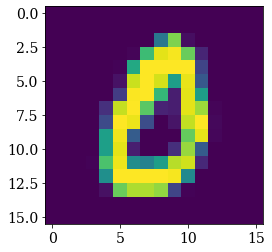

In [34]:
i = 37
x_train_node, y_train_node = filter_pair(x_train, y_train, 0, 2 + 1)
x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
plt.imshow(x_train_small[i].reshape(16, 16))

In [35]:
jnp.mean(pred_comb(params_list, x_train_small[:100], k, d_mode='GMM').argmax(axis=-1) == y_train_node[:100].argmax(axis=-1))

DeviceArray(0.96999997, dtype=float32)

In [36]:
jnp.mean(pred_comb(params_list, x_train_small[:100], k, d_mode='DM').argmax(axis=-1) == y_train_node[:100].argmax(axis=-1))

DeviceArray(0.93, dtype=float32)

In [37]:
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

In [38]:
jnp.mean(pred_comb(params_list, x_test[:1024], k, d_mode='GMM').argmax(axis=-1) == y_test[:1024])

DeviceArray(0.90234375, dtype=float32)

In [43]:
-jnp.mean(jnp.log(pred_comb(params_list, x_test[:1024], k, d_mode='GMM'))*jax.nn.one_hot(y_test[:1024], n_node))

DeviceArray(0.07792978, dtype=float32)

In [40]:
jnp.mean(pred_comb(params_list, x_test[:1024], k, d_mode='DM').argmax(axis=-1) == y_test[:1024])

DeviceArray(0.67578125, dtype=float32)

In [44]:
-jnp.mean(jnp.log(pred_comb(params_list, x_test[:1024], k, d_mode='DM'))*jax.nn.one_hot(y_test[:1024], n_node))

DeviceArray(0.13632911, dtype=float32)